## Objective
This notebook analyzes user trading and activity data to:
1. Understand market dynamics and user behavior.
2. Identify potentially suspicious (fraud-like) user patterns.
3. Provide a data-driven recommendation for a targeted marketing campaign.


## Assumptions
- All timestamps are UNIX timestamps in seconds.
- A fixed exchange rate of **1 USD = 1500 (local currency)** is used for all conversions, as specified.
- Each `user_id` uniquely identifies a single user.
- Fraud labels are **rule-based** and represent *suspicious behavior*, not confirmed fraud.

## Tools Used
- Python (Pandas, NumPy)
- Matplotlib / Seaborn
- Scikit-learn


In [81]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score


In [82]:
trades = pd.read_csv("trades.csv")
user_activity = pd.read_csv("user_activity.csv")


In [83]:
trades.head(), user_activity.head()


(      pair    amount     volume  side                    timestamp  \
 0  AAVENGN    500.26   0.001222   buy  2024-12-03T01:42:07.072672Z   
 1   ADANGN    889.20   0.500000  sell  2024-12-02T11:29:56.860014Z   
 2   ADANGN  30653.12  17.100000  sell   2024-11-30T05:25:49.99166Z   
 3   ADANGN   1978.36   1.100000  sell  2024-12-07T07:41:02.191598Z   
 4   ADANGN   2913.62   1.600000  sell  2024-12-07T21:16:11.791118Z   
 
                     user_id  
 0    541-1561-1521-1561-148  
 1    491-1541-1521-1571-156  
 2  1021-1481-1521-1561-1100  
 3    981-1571-1521-1971-151  
 4    981-1571-1521-1971-151  ,
   asset    amount activity_type                    timestamp  \
 0   NGN  131062.0    withdrawal  2025-01-17T14:37:56.806446Z   
 1   NGN   50000.0    withdrawal  2025-01-17T14:37:56.818033Z   
 2   NGN  131062.0       deposit  2025-01-17T14:37:56.853225Z   
 3   NGN   20064.0    withdrawal  2025-01-17T17:05:18.201218Z   
 4   NGN    2000.0    withdrawal  2025-01-17T14:38:22.555744

In [84]:
print("Trades shape:", trades.shape)
print("User activity shape:", user_activity.shape)

trades.info()
user_activity.info()


Trades shape: (2324, 6)
User activity shape: (4845, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2324 entries, 0 to 2323
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pair       2324 non-null   object 
 1   amount     2324 non-null   float64
 2   volume     2324 non-null   float64
 3   side       2324 non-null   object 
 4   timestamp  2324 non-null   object 
 5   user_id    2324 non-null   object 
dtypes: float64(2), object(4)
memory usage: 109.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4845 entries, 0 to 4844
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   asset          4845 non-null   object 
 1   amount         4845 non-null   float64
 2   activity_type  4845 non-null   object 
 3   timestamp      4845 non-null   object 
 4   user_id        4845 non-null   object 
dtypes: float64(1), object(4)
memory usage: 189.4+ 

In [85]:
trades["timestamp"] = pd.to_datetime(trades["timestamp"], errors="coerce")
user_activity["timestamp"] = pd.to_datetime(user_activity["timestamp"], errors="coerce")


In [86]:
trades["timestamp"].min(), trades["timestamp"].max()


(Timestamp('2024-11-27 20:37:50.972565+0000', tz='UTC'),
 Timestamp('2025-07-18 16:33:39.857059+0000', tz='UTC'))

In [87]:
user_activity["day_of_week"] = user_activity["timestamp"].dt.day_name()
user_activity["hour"] = user_activity["timestamp"].dt.hour


In [88]:
trades["trade_value_local"] = trades["amount"]


In [89]:
USD_RATE = 1500
trades["trade_value_usd"] = trades["trade_value_local"] / USD_RATE


In [90]:
pair_volume_usd = (
    trades
    .groupby("pair")["trade_value_usd"]
    .sum()
    .sort_values(ascending=False)
)


In [91]:
top_3_pairs = pair_volume_usd.head(3)
top_3_pairs


pair
BTCNGN     136215.488680
USDTNGN     59180.573580
ETHNGN       9764.589513
Name: trade_value_usd, dtype: float64

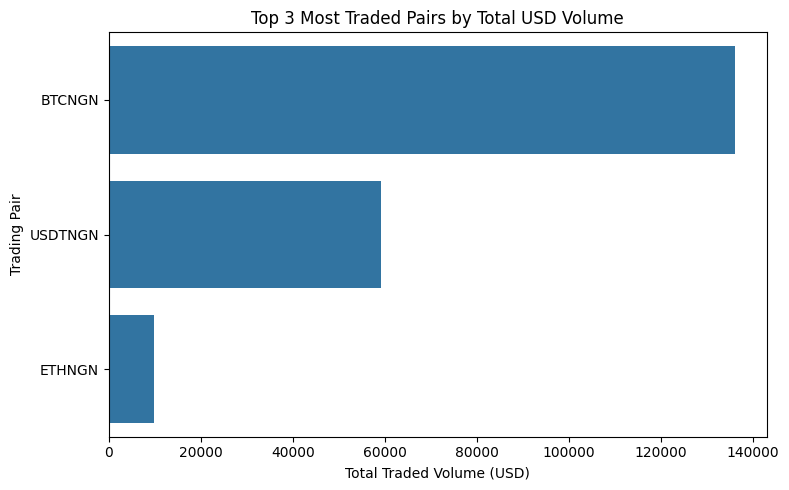

In [92]:
plt.figure(figsize=(8, 5))
sns.barplot(
    x=top_3_pairs.values,
    y=top_3_pairs.index
)
plt.title("Top 3 Most Traded Pairs by Total USD Volume")
plt.xlabel("Total Traded Volume (USD)")
plt.ylabel("Trading Pair")
plt.tight_layout()
plt.show()


## Market Dynamics Insight

The top three trading pairs account for a significant share of total traded USD volume,
indicating strong liquidity concentration around a small number of markets.
This suggests users primarily trade major pairs, which are likely the platform’s
main drivers of transaction fees and market activity.


In [93]:
btc_trades = trades[trades["pair"] == "BTCNGN"].copy()


In [94]:
btc_trades["price"] = btc_trades["amount"] / btc_trades["volume"]


In [95]:
btc_trades[["price"]].describe()


,price
count,1.035000e+03
mean,1.549660e+08
std,8.173345e+06
min,1.183292e+08
25%,1.523449e+08
50%,1.568867e+08
75%,1.596966e+08
max,1.760188e+08


In [96]:
btc_trades["date"] = btc_trades["timestamp"].dt.date

daily_price = (
    btc_trades
    .groupby("date")["price"]
    .mean()
    .to_frame("daily_price")
)


In [97]:
daily_price["daily_return"] = daily_price["daily_price"].pct_change()


In [98]:
daily_price["daily_volatility"] = daily_price["daily_return"].abs()


In [99]:
daily_price["volatility_7d"] = (
    daily_price["daily_volatility"]
    .rolling(window=7)
    .mean()
)


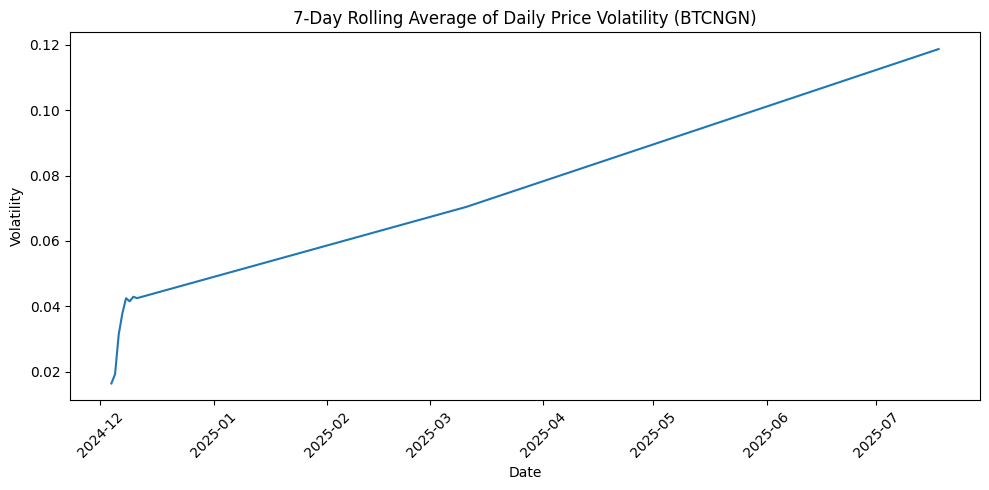

In [100]:
plt.figure(figsize=(10, 5))
plt.plot(daily_price.index, daily_price["volatility_7d"])
plt.title("7-Day Rolling Average of Daily Price Volatility (BTCNGN)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Volatility Insight – BTCNGN

The 7-day rolling average highlights periods of elevated and reduced price volatility
for the BTCNGN pair. Spikes in volatility likely correspond to periods of increased
trading activity or market uncertainty, while flatter periods suggest relative price stability.

This analysis helps identify risk-sensitive periods that may impact trader behavior
and liquidity conditions on the platform.


In [101]:
deposits = user_activity[user_activity["activity_type"] == "deposit"].copy()


In [102]:
deposits.shape


(1601, 7)

In [103]:
deposits["day_of_week"] = deposits["timestamp"].dt.day_name()
deposits["hour"] = deposits["timestamp"].dt.hour


In [104]:
deposits_by_day = (
    deposits
    .groupby("day_of_week")["amount"]
    .sum()
    .reindex([
        "Monday", "Tuesday", "Wednesday",
        "Thursday", "Friday", "Saturday", "Sunday"
    ])
)


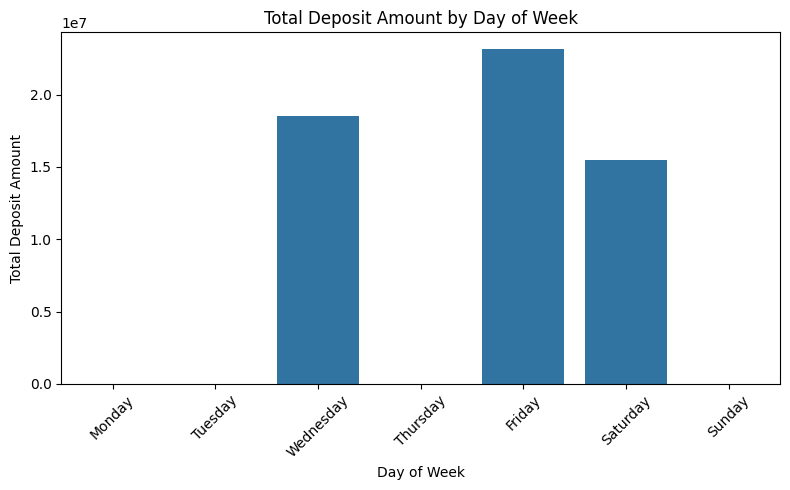

In [105]:
plt.figure(figsize=(8, 5))
sns.barplot(
    x=deposits_by_day.index,
    y=deposits_by_day.values
)
plt.title("Total Deposit Amount by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Total Deposit Amount")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [106]:
deposits_by_hour = (
    deposits
    .groupby("hour")["amount"]
    .sum()
)


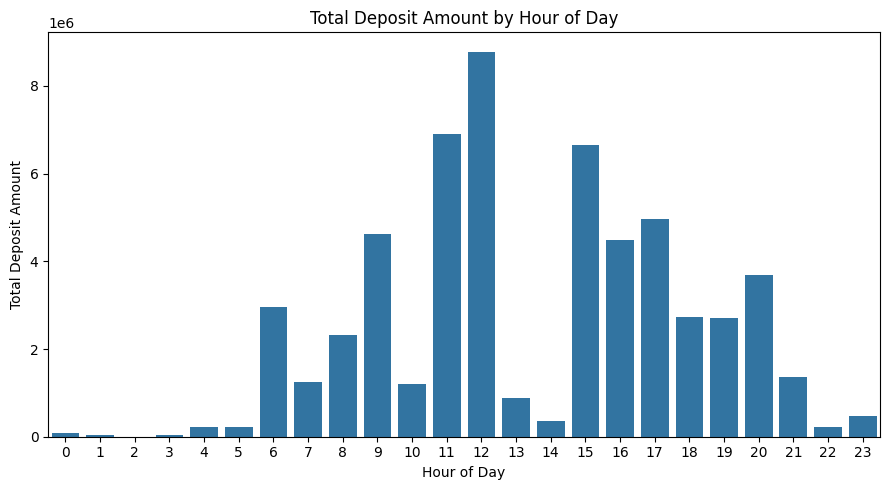

In [107]:
plt.figure(figsize=(9, 5))
sns.barplot(
    x=deposits_by_hour.index,
    y=deposits_by_hour.values
)
plt.title("Total Deposit Amount by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Total Deposit Amount")
plt.tight_layout()
plt.show()


## User Behavior Insight – Deposits

Deposit activity shows clear temporal patterns across both days of the week and hours of the day.
Peak deposit periods likely correspond to times when users are most active or financially liquid.

These insights can inform:
- Timing of promotions or campaigns
- System capacity planning
- Customer support staffing during high-activity windows


## Fraud Definition

A suspicious user is defined as one who:
1. Makes one or more deposits,
2. Executes minimal trading activity relative to deposited funds,
3. Withdraws most or all funds shortly after the first deposit.

This reflects a common fraud pattern where the platform is used
as a pass-through rather than for genuine trading.


In [108]:
activity_agg = (
    user_activity
    .groupby(["user_id", "activity_type"])["amount"]
    .sum()
    .unstack(fill_value=0)
    .reset_index()
)

activity_agg["deposit_withdraw_ratio"] = (
    activity_agg["withdrawal"] / activity_agg["deposit"]
).replace([np.inf, np.nan], 0)


In [109]:
first_deposit = (
    user_activity[user_activity["activity_type"] == "deposit"]
    .groupby("user_id")["timestamp"]
    .min()
)

first_withdrawal = (
    user_activity[user_activity["activity_type"] == "withdrawal"]
    .groupby("user_id")["timestamp"]
    .min()
)

time_diff = (
    (first_withdrawal - first_deposit)
    .dt.total_seconds()
    .reset_index(name="seconds_to_withdrawal")
)


In [110]:
trade_agg = (
    trades
    .groupby("user_id")
    .agg(
        total_trade_amount=("amount", "sum"),
        trade_count=("amount", "count"),
        unique_pairs=("pair", "nunique")
    )
    .reset_index()
)


In [111]:
features = (
    activity_agg
    .merge(time_diff, on="user_id", how="left")
    .merge(trade_agg, on="user_id", how="left")
)

features.fillna(0, inplace=True)


## Rule-Based Fraud Labeling

Since there is no ground-truth fraud label in the dataset, a rule-based approach
is used to define suspicious user behavior.

A user is labeled as suspicious if they:
- Withdraw at least 80% of their deposited funds,
- Execute trades amounting to less than 30% of their total deposit,
- Initiate withdrawal within 48 hours of their first deposit.

This rule reflects a common fraud pattern where users minimally interact with
the trading platform before quickly withdrawing funds.


In [112]:
features["trade_deposit_ratio"] = (
    features["total_trade_amount"] / features["deposit"]
).replace([np.inf, np.nan], 0)


In [113]:
features["is_suspicious"] = (
    (features["deposit_withdraw_ratio"] >= 0.8) &
    (features["trade_deposit_ratio"] < 0.3) &
    (features["seconds_to_withdrawal"] <= 172800)
).astype(int)


In [114]:
features["is_suspicious"].value_counts(normalize=True)


is_suspicious
0    0.994996
1    0.005004
Name: proportion, dtype: float64

In [115]:
X = features.drop(columns=["user_id", "is_suspicious"])
y = features["is_suspicious"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [116]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train_scaled, y_train)


LogisticRegression()

In [117]:
y_pred = model.predict(X_test_scaled)

print(classification_report(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       358
           1       1.00      0.50      0.67         2

    accuracy                           1.00       360
   macro avg       1.00      0.75      0.83       360
weighted avg       1.00      1.00      1.00       360

Recall: 0.5
Precision: 1.0


## Model Evaluation

In fraud detection, **recall is more important than precision**.
Failing to identify a suspicious user poses higher risk than
incorrectly flagging a legitimate one, which can be reviewed manually.

Therefore, recall is used as the primary evaluation metric for this model.


## Strategic Recommendation – Low-Volume Trader Campaign (Kenya)

To define a target audience for a "Low-Volume Trader" marketing campaign in Kenya,
the following data-driven criteria would be used:

1. **Low Trading Volume**
   - Users whose total trading amount falls within the bottom segment of all traders.
   - This identifies users who engage with the platform but trade infrequently or in small sizes.

2. **High Deposit-to-Trade Ratio**
   - Users who deposit funds but convert only a small portion into actual trades.
   - This suggests hesitation, lack of confidence, or early-stage adoption behavior.

3. **Limited Asset or Pair Diversity**
   - Users trading a very small number of pairs or assets.
   - This indicates basic usage patterns and an opportunity to educate users on broader trading options.

This segment represents users with existing platform engagement but untapped trading potential.
Targeted education, reduced trading fees, and localized incentives could encourage deeper
participation while minimizing acquisition costs.
